In [10]:
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
from imageio import imread
# from skimage.data import imread
from scipy.misc import imresize
from keras.utils import to_categorical
%matplotlib inline

# Settings:
img_size = 45
grayscale_images = True
num_class = 10
test_size = 0.15 # 308 samples for each class. 

# Input data files are available in the "../input/" directory.
from subprocess import check_output
data_path='sign_language_dataset_color/Dataset'
print(check_output(["ls",data_path]).decode('utf8'))


0
1
2
3
4
5
6
7
8
9
x.csv
x_45.csv
y.csv
y_45.csv



### First time step if reading from original dataset:

In [11]:
labels = [int(x) for x in listdir(data_path) if ('x' not in x) and ('y' not in x)]
labels.sort()
print(labels)

def read_dataset(): # read from original 100*100 color dataset
    X = []
    Y = []

    for i, label in enumerate(labels):
        i_path = data_path+'/' + str(label)
        for file in listdir(i_path):
            if file[0] != '.':
                img = imread(i_path+'/'+file, as_gray=grayscale_images)
                img = imresize(img, (img_size, img_size, 1 if grayscale_images else 3)) # 45*45
                X.append(img)
                Y.append(i)

    X = np.array(X).astype(int)
    Y = np.array(Y).astype(int)
    Y = to_categorical(Y, num_class)

    print(X.shape)
    print(Y.shape)

    np.savetxt(data_path+'/'+"x_45.csv", X.reshape(X.shape[0],img_size*img_size), delimiter=",", fmt='%i')
    np.savetxt(data_path+'/'+"y_45.csv", Y, delimiter=",", fmt='%i')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## Dataset Visualization & Splitting

data: (2050, 2025) labels:  (2050, 10)
test labels:  [0 1 3 5 7 9]
mean:  173.5657548931045


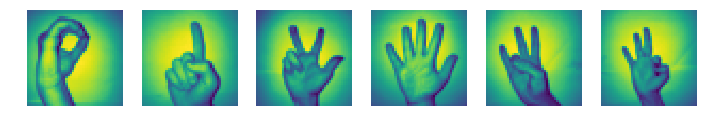

In [13]:
X = np.genfromtxt(data_path+'/x_45.csv', delimiter=',')
Y = np.genfromtxt(data_path+'/y_45.csv', delimiter=',')

test_rows = np.arange(0, X.shape[0], 400)
print('data:', X.shape, 'labels: ', Y.shape)
print('test labels: ', np.argmax(Y[test_rows], axis=1))
print('mean: ', np.mean(X))

nrows= len(test_rows)
plt.figure(figsize=(12,8))
for i in range(0, nrows): 
    plt.subplot(1,nrows,i+1)
    plt.imshow(X[test_rows[i]].reshape(img_size,img_size))
    plt.axis('off')


In [14]:
# Then lets create x_train, y_train, x_test, y_test arrays
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_s = sc.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_s, Y, test_size= test_size, random_state=0)
x_train = X_train.reshape(X_train.shape[0],img_size, img_size)
x_test = X_test.reshape(X_test.shape[0],img_size, img_size)
print(x_train.shape)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)


(1742, 45, 45)
(1742, 2025) (308, 2025) (1742, 10) (308, 10)


## Training the CNN Model

In [15]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, Conv1D, MaxPooling2D, MaxPooling1D
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras import backend as K
import time

def get_fnn_classifier():
    k_classifier = Sequential()
    k_classifier.add(Dense(units= 8, activation='relu', input_dim=X_train.shape[1]))
#     k_classifier.add(Dense(units= 3, activation='relu'))
    k_classifier.add(Dense(units= 10, activation='sigmoid'))
    k_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return k_classifier

def get_cnn_classifier_64():
    opt_a = Adam(lr=0.00044, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=True)
    
    model = Sequential()
#     keras.layers.Conv1D(filters, kernel_size, strides=1, padding='valid', 
#     data_format='channels_last', dilation_rate=1, activation=None, 
#     use_bias=True, kernel_initializer='glorot_uniform' bias_initializer='zeros')

    model.add(Conv1D(32, 3, padding='same', input_shape=x_train.shape[1:], name='conv1d_1'))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    
    model.add(Conv1D(32, 3, padding='same', name="conv1d_2"))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    model.add(Dropout(0.25))
    
    model.add(Conv1D(16, 3, padding='same', name="conv1d_3"))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(300, name='dense_1'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_class, name='dense_2'))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer=opt_a,
              metrics=['accuracy'])
    
    return model

def get_cnn_classifier_45():
    opt_a = Adam(lr=0.00044, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=True)
    
    model = Sequential()
#     keras.layers.Conv1D(filters, kernel_size, strides=1, padding='valid', 
#     data_format='channels_last', dilation_rate=1, activation=None, 
#     use_bias=True, kernel_initializer='glorot_uniform' bias_initializer='zeros')

    model.add(Conv1D(32, 3, padding='same', input_shape=x_train.shape[1:], name='conv1d_1'))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    
    model.add(Conv1D(32, 3, padding='same', name="conv1d_2"))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    model.add(Dropout(0.25))
    
    model.add(Conv1D(16, 3, padding='same', name="conv1d_3"))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())
#     model.add(Dense(300, name='dense_1'))
#     model.add(Activation('relu'))
#     model.add(Dropout(0.5))
    model.add(Dense(num_class, name='dense_2'))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer=opt_a,
              metrics=['accuracy'])
    
    return model

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [16]:
model = get_cnn_classifier_45()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True) # Plot CNN Model
reset_weights(model)

In [18]:
model = get_cnn_classifier_45()
model.load_weights('output_45/0.9253_0.2990.hdf5') # Saving best model for quantization
model.save('my_model.h5')

In [17]:
tb = TensorBoard(log_dir='logs_sign/log_45_'+time.strftime("%H:%M:%S"), batch_size=32, write_graph=True, write_images=True)
es = EarlyStopping(monitor='val_loss', min_delta=0.01,patience=10,verbose=0, mode='auto')
checkpoint = ModelCheckpoint('output_45/{val_acc:.4f}_{val_loss:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')

model.fit(x_train, Y_train,
              batch_size=32,
              epochs=200,
              validation_data=(x_test, Y_test),
              shuffle=True, callbacks =[tb, checkpoint])
# accuracy= cross_val_score(estimator= classifier, X=x_train, y=Y_train, cv=3)

# print('Val accuracy: ', accuracy)
score = model.evaluate(x_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 1742 samples, validate on 308 samples
Epoch 1/200
1742/1742 [==============================] - 2s 1ms/step - loss: 2.4390 - acc: 0.1102 - val_loss: 2.2698 - val_acc: 0.1429

Epoch 00001: val_acc improved from -inf to 0.14286, saving model to output_45/0.1429_2.2698.hdf5
Epoch 2/200
1742/1742 [==============================] - 1s 810us/step - loss: 2.2422 - acc: 0.1774 - val_loss: 2.1770 - val_acc: 0.2045

Epoch 00002: val_acc improved from 0.14286 to 0.20455, saving model to output_45/0.2045_2.1770.hdf5
Epoch 3/200
1742/1742 [==============================] - 2s 1ms/step - loss: 2.1452 - acc: 0.2411 - val_loss: 2.0615 - val_acc: 0.3084

Epoch 00003: val_acc improved from 0.20455 to 0.30844, saving model to output_45/0.3084_2.0615.hdf5
Epoch 4/200
1742/1742 [==============================] - 1s 619us/step - loss: 1.9945 - acc: 0.3025 - val_loss: 1.8968 - val_acc: 0.3864

Epoch 00004: val_acc improved from 0.30844 to 0.38636, saving model to output_45/0.3864_1.8968.hdf5
Epoch 5/

1742/1742 [==============================] - 1s 661us/step - loss: 0.5529 - acc: 0.8117 - val_loss: 0.4956 - val_acc: 0.8344

Epoch 00037: val_acc improved from 0.83117 to 0.83442, saving model to output_45/0.8344_0.4956.hdf5
Epoch 38/200
1742/1742 [==============================] - 1s 769us/step - loss: 0.5043 - acc: 0.8301 - val_loss: 0.4992 - val_acc: 0.8312

Epoch 00038: val_acc did not improve from 0.83442
Epoch 39/200
1742/1742 [==============================] - 1s 841us/step - loss: 0.5485 - acc: 0.8146 - val_loss: 0.4973 - val_acc: 0.8247

Epoch 00039: val_acc did not improve from 0.83442
Epoch 40/200
1742/1742 [==============================] - 2s 1ms/step - loss: 0.4920 - acc: 0.8393 - val_loss: 0.4822 - val_acc: 0.8377

Epoch 00040: val_acc improved from 0.83442 to 0.83766, saving model to output_45/0.8377_0.4822.hdf5
Epoch 41/200
1742/1742 [==============================] - 1s 833us/step - loss: 0.5189 - acc: 0.8318 - val_loss: 0.4705 - val_acc: 0.8409

Epoch 00041: val_acc

1742/1742 [==============================] - 1s 778us/step - loss: 0.2544 - acc: 0.9168 - val_loss: 0.3607 - val_acc: 0.8961

Epoch 00077: val_acc did not improve from 0.89610
Epoch 78/200
1742/1742 [==============================] - 1s 822us/step - loss: 0.2677 - acc: 0.9093 - val_loss: 0.3520 - val_acc: 0.8864

Epoch 00078: val_acc did not improve from 0.89610
Epoch 79/200
1742/1742 [==============================] - 1s 756us/step - loss: 0.2255 - acc: 0.9305 - val_loss: 0.3395 - val_acc: 0.8961

Epoch 00079: val_acc did not improve from 0.89610
Epoch 80/200
1742/1742 [==============================] - 1s 762us/step - loss: 0.2557 - acc: 0.9110 - val_loss: 0.3492 - val_acc: 0.8961

Epoch 00080: val_acc did not improve from 0.89610
Epoch 81/200
1742/1742 [==============================] - 1s 802us/step - loss: 0.2434 - acc: 0.9179 - val_loss: 0.3507 - val_acc: 0.8994

Epoch 00081: val_acc improved from 0.89610 to 0.89935, saving model to output_45/0.8994_0.3507.hdf5
Epoch 82/200
1742/

1742/1742 [==============================] - 2s 1ms/step - loss: 0.1637 - acc: 0.9524 - val_loss: 0.3259 - val_acc: 0.9188

Epoch 00119: val_acc did not improve from 0.91883
Epoch 120/200
1742/1742 [==============================] - 1s 757us/step - loss: 0.1609 - acc: 0.9506 - val_loss: 0.3412 - val_acc: 0.9123

Epoch 00120: val_acc did not improve from 0.91883
Epoch 121/200
1742/1742 [==============================] - 2s 905us/step - loss: 0.1481 - acc: 0.9518 - val_loss: 0.3304 - val_acc: 0.9026

Epoch 00121: val_acc did not improve from 0.91883
Epoch 122/200
1742/1742 [==============================] - 1s 495us/step - loss: 0.1943 - acc: 0.9351 - val_loss: 0.3278 - val_acc: 0.9091

Epoch 00122: val_acc did not improve from 0.91883
Epoch 123/200
1742/1742 [==============================] - 1s 822us/step - loss: 0.1506 - acc: 0.9455 - val_loss: 0.3390 - val_acc: 0.9058

Epoch 00123: val_acc did not improve from 0.91883
Epoch 124/200
1742/1742 [==============================] - 1s 778u

1742/1742 [==============================] - 1s 501us/step - loss: 0.1072 - acc: 0.9610 - val_loss: 0.3078 - val_acc: 0.9026

Epoch 00162: val_acc did not improve from 0.92208
Epoch 163/200
1742/1742 [==============================] - 1s 490us/step - loss: 0.1048 - acc: 0.9638 - val_loss: 0.3278 - val_acc: 0.8994

Epoch 00163: val_acc did not improve from 0.92208
Epoch 164/200
1742/1742 [==============================] - 1s 486us/step - loss: 0.1249 - acc: 0.9587 - val_loss: 0.3266 - val_acc: 0.9091

Epoch 00164: val_acc did not improve from 0.92208
Epoch 165/200
1742/1742 [==============================] - 1s 502us/step - loss: 0.1077 - acc: 0.9627 - val_loss: 0.3427 - val_acc: 0.9091

Epoch 00165: val_acc did not improve from 0.92208
Epoch 166/200
1742/1742 [==============================] - 1s 491us/step - loss: 0.1159 - acc: 0.9592 - val_loss: 0.3209 - val_acc: 0.9058

Epoch 00166: val_acc did not improve from 0.92208
Epoch 167/200
1742/1742 [==============================] - 1s 49

## Creating inputs.h file for ARM CMSIS code

test labels:  [5 1 4 2 4 2 1 7 0 6]
mean:  174.4303623536957


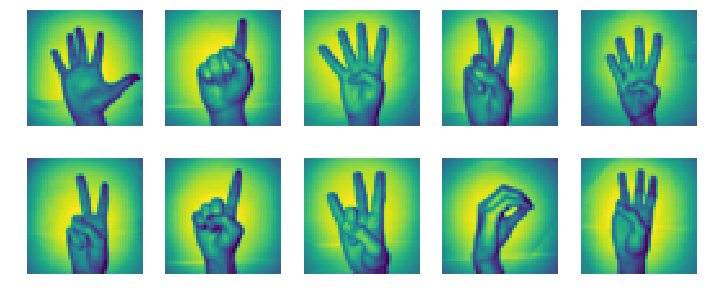

In [19]:
# get an unscaled x_test
x_test_original = sc.inverse_transform(X_test)

n_rows = 10 # number of test samples to select
test_rows = np.random.randint(0, x_test_original.shape[0], size=n_rows) # 10 random images from testing dataset
print('test labels: ', np.argmax(Y_test[test_rows], axis=1))
print('mean: ', np.mean(x_test_original))

fig = plt.figure(figsize=(12,5))
for i in range(0, n_rows):
    fig.add_subplot(2, 5, i+1)
    img = x_test_original[test_rows[i]].reshape(img_size,img_size)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [20]:
# Predictions for these test images:
y_pred= model.predict(x_test[test_rows])
pred = np.argmax(y_pred, axis=1)
pred

array([5, 1, 4, 2, 4, 2, 1, 7, 0, 6])

In [21]:
inputs_file = open('arm_sign_nb_45/arm_sign_nb_inputs.h', 'w')
inputs_file.write('/* 10 test images \n true labels: '+str(np.argmax(Y_test[test_rows], axis=1))
                  +' \n pred labels:'+str(pred)+'*/\n')

common = '#define IMG_DATA {'

for i in test_rows:
    inputs_file.write('// ' + common)
    x_test_original[i].tofile(inputs_file, sep=',', format='%d')
    inputs_file.write('}\n')

inputs_file.close()